In [1]:
import sys
import os
import json
import tensorflow as tf
import tqdm
from models.model import *
from losses.metric import *
from ltv_utils import *
from losses.custom_loss import *
pd.set_option('display.float_format', '{:.4f}'.format)  # 保留10位小数，可调整
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)



def parse_function(serialized_example):
    feature_description = {
        'deviceid': tf.io.FixedLenFeature([], tf.string),
        'install_date': tf.io.FixedLenFeature([], tf.string),
        'dim_os_name1': tf.io.FixedLenFeature([], tf.string),
        'creative_classify1': tf.io.FixedLenFeature([], tf.string),
        'total_pay_amount1':  tf.io.FixedLenFeature([], tf.float32),
         'channel1': tf.io.FixedLenFeature([], tf.string),
        'b2_sale_amt_bias':  tf.io.FixedLenFeature([], tf.int64),
         'b2_sale_amt_7d': tf.io.FixedLenFeature([], tf.int64),
         'install_time': tf.io.FixedLenFeature([], tf.string),
        'install_order_diff':  tf.io.FixedLenFeature([], tf.int64),
        'all_install_order_7d_diff':  tf.io.FixedLenFeature([], tf.int64),
        'is_a1x_a33':  tf.io.FixedLenFeature([], tf.int64),
        'platform_label':  tf.io.FixedLenFeature([], tf.string),
        'user_dense_price_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_price_features'])], tf.float32),
        'user_dense_duration_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_duration_features'])], tf.float32),
        'user_dense_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_features'])], tf.float32),
        'user_sparse_features': tf.io.FixedLenFeature([len(group_2_features['user_sparse_features'])], tf.float32)
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    return example


# load tf records
group_2_features = read_feature_json_config('features/feature_list.json')

train_file_name = 'data/ltv_0522_0603_multi_window_model_train/part-r-00000'
valid_file_name = 'data/ltv_0522_0603_multi_window_model_valid/part-r-00000'

train_dataset, valid_dataset, _ = get_trian_valid_test_dateset(parse_function, 4096, train_file_name, valid_file_name)



user_dense_price_features = group_2_features['user_dense_price_features']
user_dense_duration_features = group_2_features['user_dense_duration_features']
user_dense_features = group_2_features['user_dense_features']
user_sparse_features = group_2_features['user_sparse_features']


2025-06-26 11:18:29.962367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-26 11:18:30.126226: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-26 11:18:30.131502: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-26 11:18:30.131520: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
MODEL_HOUR = 0 

In [3]:
def create_tf_dataset(dataset):
    sample_batch = next(iter(dataset))
    sample_data = {k: v for k, v in sample_batch.items() if k not in ['b2_sale_amt_7d', 'total_pay_amount1']}

    
    def generator():
        for batch in dataset:
            hour = tf.cast(tf.gather(batch['user_sparse_features'],  indices=0, axis = 1) - 1, tf.int64)    # shape: (batch_size,)
            b2_7d = tf.cast(tf.reshape(batch.pop('b2_sale_amt_7d'), (-1, 1)), tf.float32)
            total_amt_1h = tf.reshape(batch.pop('total_pay_amount1'), (-1, 1))

            # 只保留 hour 为 MODEL_HOUR 的记录
            hour_mask = tf.equal(hour, MODEL_HOUR)  # shape: (batch_size,)
            hour_mask = tf.reshape(hour_mask, (-1, 1))  # 广播成 (batch_size, 1)
            
            # 使用 hour_mask 筛选 batch 中的所有字段
            selected_indices = tf.where(hour_mask)[:, 0]  # 获取 hour == 1 的样本索引
            batch = {k: tf.gather(v, selected_indices, axis=0) for k, v in batch.items()}  # 筛选 batch 中的样本

            # 筛选 b2_7d 和 total_amt_1h 对应的标签
            b2_7d = tf.gather(b2_7d, selected_indices, axis=0)  # 保留 hour == 1 对应的标签
            total_amt_1h = tf.gather(total_amt_1h, selected_indices, axis=0)  # 保留 hour == 1 对应的标签

            
    
            # 将保留的样本和标签一起返回
            y_true_packed = b2_7d - total_amt_1h
            # y_true_packed = b2_7d
            # y_true_packed = b2_7d
            yield batch, y_true_packed
        

    # 正确写法：output_signature 中保留每个字段的真实 shape
    output_signature = (
        {
            name: tf.TensorSpec(shape=(None,) + v.shape[1:], dtype=v.dtype)
            for name, v in sample_data.items()
        },
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)

In [4]:

emb_features = [
'creative_classify','dim_device_manufacture', 'car_add_type_most','show_order_is_2arrival_latest', 'selecttirecount_most', 'show_order_is_2arrival_most','selecttirecount_latest',
 'new_sitename','advsite','car_add_type_latest','platform_level', 'tire_list_click_avg_index','tire_list_click_most_pid_level','tire_order_page_most_pid_level',
]



model = MULTI_HEAD_LTV_MODEL(5, [128], [64], 'user_dense_features', 'user_dense_price_features', 'user_dense_duration_features',
                            'user_sparse_features',user_sparse_features, emb_features)


sample = next(iter(train_dataset))
input_shape = {k: v.shape for k, v in sample.items()}


In [5]:
# 自己实现的单口loss
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse',  
    restore_best_weights=True ,
    patience=3
)

loss_fn = UnifiedLTVsimple('mse')
       
model.compile(
    loss=loss_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)


In [19]:
# todo 明天实现按照auc 早停的逻辑
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_gini_metric',  # 或'val_rmse'
    mode='max',  # 基尼系数越大越好
    patience=3,
    restore_best_weights=True
)

model.compile(
    loss=UnifiedLTVsimple('log'),
    optimizer='adam',
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        PureTFGiniMetric()  # 需确保实现正确
    ]
)

TypeError: add_weight() got an unexpected keyword argument 'trainable'

In [ ]:
# # 自己实现的双口loss
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_rmse',  # 监控验证集上的 loss
#     patience=3,          # 如果连续 3 轮没有改善，就停止训练
#     restore_best_weights=True  # 训练结束后恢复到最优模型
# )

# loss_fn = UnifiedLTVLoss('mse')
# model.compile(loss=loss_fn, optimizer = 'adam',  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])


In [10]:
# 官方loss
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse',       # 监控验证集 rmse
    patience=3,
    restore_best_weights=True
)
loss_fn = tf.keras.losses.MeanSquaredError()
loss_fn.mode = 'mse'
model.compile(
    loss=loss_fn,   # 使用 Keras 自带的均方误差损失
    optimizer='adam',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

In [6]:
model.fit(
    create_tf_dataset(train_dataset),
    epochs=15,
    validation_data = create_tf_dataset(valid_dataset),
    callbacks= [early_stopping]
) 

Epoch 1/15
Tensor("IteratorGetNext:15", shape=(None, 1), dtype=float32)
Tensor("IteratorGetNext:15", shape=(None, 1), dtype=float32)
736/736 [==============================] - 89s 115ms/step - rmse: 263.5234 - val_loss: 59972.5078 - val_rmse: 244.8929
Epoch 2/15
736/736 [==============================] - 85s 116ms/step - rmse: 248.9848 - val_loss: 57748.3359 - val_rmse: 240.3088
Epoch 3/15
736/736 [==============================] - 87s 118ms/step - rmse: 245.7842 - val_loss: 56230.6445 - val_rmse: 237.1300
Epoch 4/15
736/736 [==============================] - 87s 118ms/step - rmse: 242.9843 - val_loss: 54892.4062 - val_rmse: 234.2913
Epoch 5/15
736/736 [==============================] - 85s 115ms/step - rmse: 240.7940 - val_loss: 53710.2188 - val_rmse: 231.7547
Epoch 6/15
736/736 [==============================] - 89s 120ms/step - rmse: 239.3101 - val_loss: 52932.2188 - val_rmse: 230.0700
Epoch 7/15
736/736 [==============================] - 84s 113ms/step - rmse: 238.3843 - val_loss: 

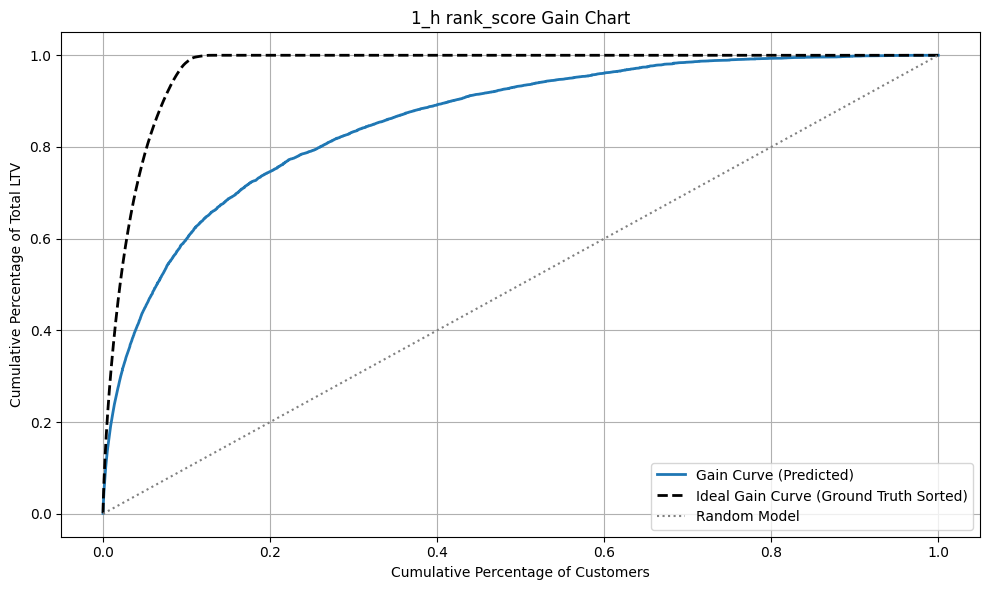

{'1_h rank_score': 0.8577046612566372}

In [8]:
hour_model_pred = model.evaluate_rank(create_tf_dataset(valid_dataset))
hour_model_pred

In [9]:
hour_model_pred

{'1_h rank_score': 0.8577046612566372}